**решающее дерево**

Евгений Борисов borisov.e@solarl.ru

---

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from tree import Node
from tree import Leaf

In [3]:
def get_seed(): t = time() ; return int(((t%1)/t)*1e11)
get_seed()

41

In [4]:
n_samples = 500
# n_cls = 2 # количество классов

In [5]:
# from sklearn.datasets import make_blobs

# X,y = make_blobs( 
#         n_samples=n_samples,
#         centers=n_cls,  
#         random_state=get_seed(),
#         cluster_std=[1.0, 1.5]
#     )

In [6]:
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=n_samples, noise=.09, random_state=get_seed())


In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=get_seed() )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

In [8]:
%xdel X
%xdel y

---

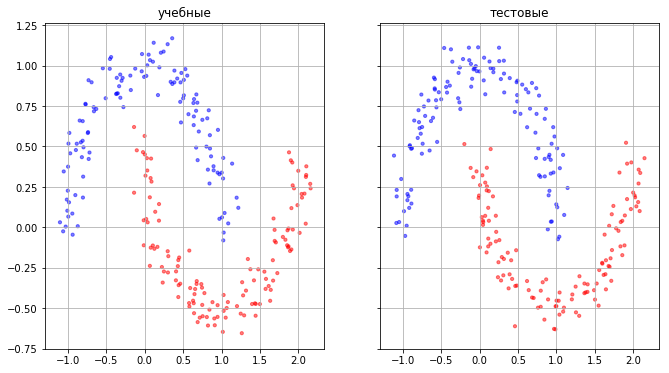

In [9]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11,6),)
    
axarr[0].set_title('учебные')
axarr[0].scatter( x=X_train[:,0], 
                  y=X_train[:,1], 
                  c=[['b','r','g','y'][j] for j in y_train ],  
                  s=10,
                  alpha=0.5 )
axarr[0].grid()

axarr[1].set_title('тестовые')
axarr[1].scatter( x=X_test[:,0], 
                  y=X_test[:,1], 
                  c=[ ['b','r','g','y'][j] for j in y_test],
                  s=10,
                  alpha=0.5 )
axarr[1].grid()

plt.show()

---

**энтропийный критерий - информационный выигрыш (Information gain)**

Пусть ω0, ω1 — два исхода с вероятностями $q$ и $1−q$    

Количество информации:  
    $$I_0 = − log2(q)$$  
    $$I_1 = − log2(1 − q)$$ 

Энтропия - математическое ожидание количества информации:  

$$h(q) = −q \cdot log2(q) − (1−q)\cdot log2(1−q)$$

Энтропия выборки $X$, если исходы — это классы $y=c$, $y\neq c$:
$$H(y) = h\left( \frac{P}{s} \right)$$

Энтропия выборки $X$ после получения информации $R$: 

$$H(y|R)=\frac{p+n}{s} \cdot h\left(\frac{p}{p+n}\right) + \frac{s-p-n}{s} \cdot h\left( \frac{P-p}{s-p-n} \right)$$


Информационный выигрыш (Information gain):
$$iGain(y,R) = H(y) − H(y|R)$$



- s - длинна выборки
- P - количество положительных примеров
- p - количество положительных примеров, выделеных предикатом
- n - количество отрицательных примеров, выделеных предикатом




In [10]:
# энтропийный критерий - информационный выигрыш (Information gain, IGain):
def h(q):
    q = min(0.999, max(1e-9,q))
    return -q*np.log2(q) - (1.0-q)*np.log2(1.0-q)

def igain(s,p_y,p,n):
    # разница в информативности, 
    # до и после примения предиката
    
    # s - количество примеров
    # p_y - количество положительных
    # p - количество положительных примеров, выделенных предикатом   
    # n - количество отрицательных примеров, выделенных предикатом
    
    return h(p_y/s) - ( (p+n)/s * h(p/(p+n)) + (s-p-n)/s * h( (p_y-p)/(s-p-n)) )

**критерий Джини**

$$Gini(y,R) = \sum_c q_c(1-q_c) = \frac{p}{p+n} \cdot \left(1- \frac{p}{p+n}\right) +  \frac{n}{p+n} \cdot \left(1- \frac{n}{p+n}\right)$$

- $q_c$ - априорная вероятность класса $c$, выделеного предикатом $R$
  
  $q_p= \frac{p}{p+n}$ ;   $q_n= \frac{n}{p+n}$ 
    
- $p$ - количество положительных примеров, выделеных предикатом
- $n$ - количество отрицательных примеров, выделеных предикатом




In [11]:
# критерий Джини
def gini(p,n):
    return (p/p+n)*(1-(p/p+n)) + (n/p+n)*(1-(n/p+n))

---

In [12]:
# def info(X,y,b):
#     f = X>b #  отмечаем примеры выделенные предикатом 
#     p = y[f].sum() # количество положительных примеров, выделенных предикатом   
#     n = -(y[~f]-1).sum() # количество отрицательных примеров, выделенных предикатом
#     return gini(p,n) # критерий Джини

In [13]:
def info(X,y,b):
    f = X>b #  отмечаем примеры выделенные предикатом 
    p = y[f].sum() # количество положительных примеров, выделенных предикатом   
    n = -(y[~f]-1).sum() # количество отрицательных примеров, выделенных предикатом
    s = len(y) #  количество примеров
    p_y = y.sum() # количество положительных
    return igain(s,p_y,p,n) # разница в информативности

Алгоритм обучения выглядит следующим образом.

1. если X содержит точки только одного класса то создать лист с меткой класса и переход на п.6

2. выбрать признак номер $i$ и найти для него пороговое значение $b$, $(min(X_i) < b < max(X_i) )$ с максимальной информативностью разделения

3. создать узел дерева и сохранить там найденную пару $(i,b)$

4. разделить $X$ на две части по признаку $i$ и его порогу $b$

5. выполнить рекурсивно с п.1 для каждого полученного на пред.шаге подмножества

6. конец работы

In [14]:
def search_split(X,y,nb=30):
    # nb = 30 # количество порогов (частей при разбиении отрезка) 

    # список порогов для каждого признака
    b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] for i in range(X.shape[1]) ])

    # изменение информативности для разных признаков и значений порогов 
    inf = np.array([ 
        [ info(X[:,i],y,b[i,j]) for i in range(X.shape[1])  ] 
        for j in range(b.shape[1]) 
    ])

    # параметры с максимальным значением информативности
    j,i = np.unravel_index(inf.argmax(),inf.shape)

    return i,b[i,j]

In [15]:
def build_subtree(X,y,nb=50,parent=None):
    if (len(y)<1) : return Leaf(mark=0,parent=parent)
        
    # если разбиение содержит точки одного класса
    if (y==1).all() or (y==0).all(): 
        return Leaf(mark=y[0],parent=parent) # то создаём лист с меткой класса
    
    # ищем оптимальное разделение по признаку
    i,b = search_split(X,y,nb)

    # создаём узел дерева
    t=Node(feature=i, bound=b,parent=parent) 
    
    # повторяем рекурсивно для двух подмножеств
    f = X[:,i]>b    
    tl = build_subtree( X[f,:],  y[f],  parent=t ) 
    tr = build_subtree( X[~f,:], y[~f], parent=t )
    t.left,t.right = tl,tr
    
    return t    



def build_dtree(X,y,nb=50):
    return build_subtree(X,y,nb=nb,parent=None)
    

In [16]:
%%time

dtree = build_dtree(X_train,y_train,nb=10)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


CPU times: user 1.02 s, sys: 10.2 ms, total: 1.03 s
Wall time: 1.05 s


In [17]:
def split_subset(X,p,Xpos,Xneg):
    if(type(p).__name__ == 'Leaf'): 
        if p.mark > 0: 
            Xpos.append(X)
        else:
            Xneg.append(X)
        return [Xpos,Xneg]

    f = X[:,p.feature]>p.bound
    
    XposL,XnegL = split_subset( X[f,:],  p.left,  Xpos, Xneg )
    XposR,XnegR = split_subset( X[~f,:], p.right, Xpos, Xneg )

    return [XposL+XposR,XnegL+XnegR]


def split_data(X,p):
    Xpos,Xneg = split_subset(X,p,[],[])
    Xpos = np.vstack(Xpos)
    Xneg = np.vstack(Xneg)
    return Xpos,Xneg


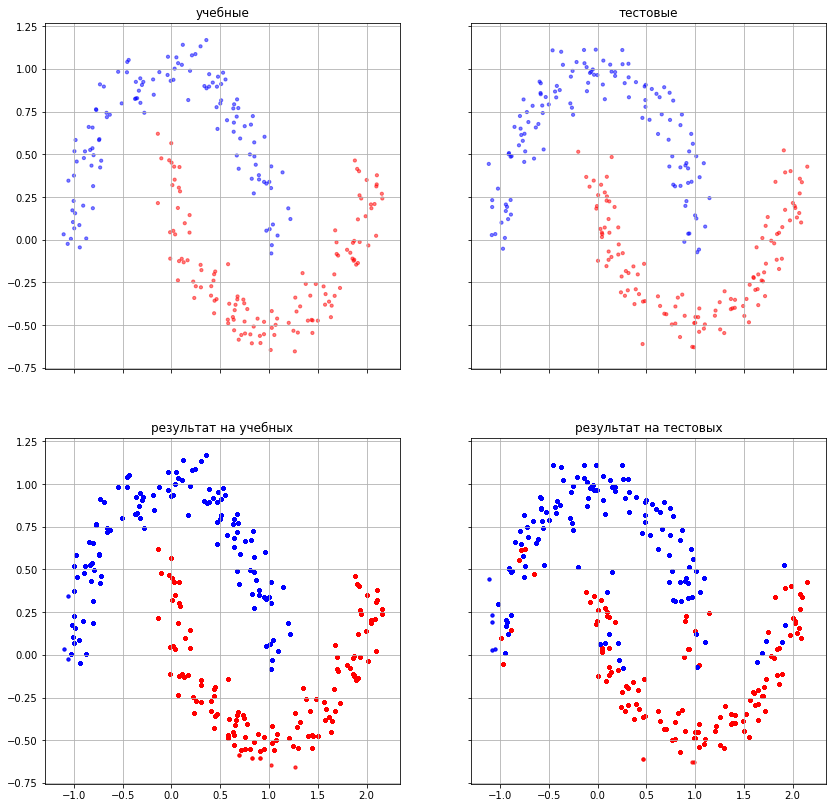

In [18]:
f, axarr = plt.subplots( 2, 2, sharey=True, sharex=True, figsize=(14,14),)


axarr[0,0].set_title('учебные')
axarr[0,0].scatter( x=X_train[:,0], y=X_train[:,1], 
                  c=[['b','r','g','y'][j] for j in y_train ],  
                  s=10, alpha=0.5 )
axarr[0,0].grid()

axarr[0,1].set_title('тестовые')
axarr[0,1].scatter( x=X_test[:,0], y=X_test[:,1], 
                  c=[ ['b','r','g','y'][j] for j in y_test],
                  s=10, alpha=0.5 )
axarr[0,1].grid()


Xpos,Xneg = split_data(X_train,dtree)
axarr[1,0].set_title('результат на учебных')
axarr[1,0].scatter(x=Xpos[:,0],y=Xpos[:,1],s=10,c='r',alpha=0.5)
axarr[1,0].scatter(x=Xneg[:,0],y=Xneg[:,1],s=10,c='b',alpha=0.5)
axarr[1,0].grid()

Xpos,Xneg = split_data(X_test,dtree)
axarr[1,1].set_title('результат на тестовых')
axarr[1,1].scatter(x=Xpos[:,0],y=Xpos[:,1],s=10,c='r',alpha=0.5)
axarr[1,1].scatter(x=Xneg[:,0],y=Xneg[:,1],s=10,c='b',alpha=0.5)
axarr[1,1].grid()

# plt.savefig('dtree-res.png')
plt.show()